# Predicting Click-Through in Online Ranking

Hotel industry in context.

In [1]:
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [2]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('train.csv')
df.shape

(9917530, 54)

In [5]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


This is a large data set with near 10 million observations and 54 features. 

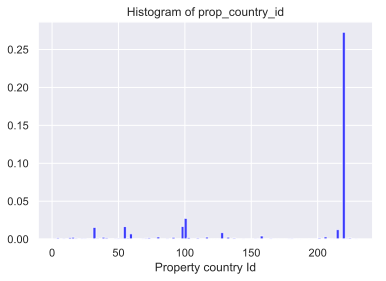

In [6]:
n, bins, patches = plt.hist(df.prop_country_id, 100, density = 1, facecolor='blue', alpha=0.75)
plt.xlabel('Property country Id')
plt.title('Histogram of prop_country_id')
plt.show();

In [7]:
df.groupby('prop_country_id').size().nlargest(5)

prop_country_id
219    6052976
100     622810
55      376219
31      309434
99      268393
dtype: int64

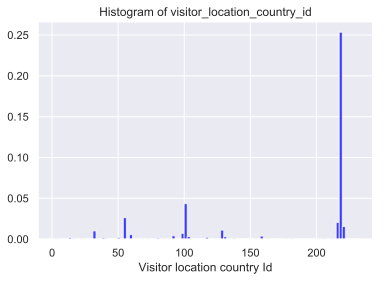

In [8]:
n, bins, patches = plt.hist(df.visitor_location_country_id, 100, density = 1, facecolor='blue', alpha=0.75)
plt.xlabel('Visitor location country Id')
plt.title('Histogram of visitor_location_country_id')
plt.show();

In [9]:
df.groupby('visitor_location_country_id').size().nlargest(5)

visitor_location_country_id
219    5778805
100     990487
55      580072
216     434568
220     350433
dtype: int64

The data is anonymized, so determining the exact country or city to which a consumer plans to travel to is not possible. However, it is evident that the largest country (labeled 219) is the United States.

In [10]:
df.visitor_location_country_id.value_counts(normalize=True)[:5]

219    0.582686
100    0.099872
55     0.058490
216    0.043818
220    0.035335
Name: visitor_location_country_id, dtype: float64

 The largest country has 61% of all observations. Out of those, 58% of searches are made by consumers also located in this country, suggesting that the country has a large territory with a large fraction of domestic travel. The price currency also suggested that the largest country being the United States.

**to improve the computational efficiency, we are going to train independent models on US visitors. **

In [11]:
us = df.loc[df['visitor_location_country_id'] == 219]

In [12]:
us.shape

(5778805, 54)

In [13]:
us = us.sample(frac=0.6, random_state=99)
del us['visitor_location_country_id']

### Missing values

In [14]:
na_sum = list(df.isnull().sum())
print(len(na_sum))

54


In [15]:
na_col = list(df.isnull().sum().index)
print(len(na_col))

54


In [16]:
drop_col =[]
for i in range(len(na_sum)):
    if na_sum[i] > 2523:
        drop_col.append(na_col[i])
print("We can drop ",len(drop_col)," Columns")

We can drop  31  Columns


In [17]:
# Checking rows now
def summary_missing(dataset):
    n_miss = dataset.isnull().sum()
    n_obs = dataset.shape[0]
    n_miss_per = n_miss/n_obs*100
    n_miss_tbl = pd.concat([n_miss, n_miss_per], axis = 1).sort_values(1, ascending = False).round(1)
    n_miss_tbl = n_miss_tbl[n_miss_tbl[1] != 0]
    print('No. of fields: ', dataset.shape[0])
    print('No. of missing fields: ', n_miss_tbl.shape[0])
    n_miss_tbl = n_miss_tbl.rename(columns = {0:'No. of mising Value', 1:'%age of missing Value'})
    return n_miss_tbl

In [18]:
summary_missing(df)

No. of fields:  9917530
No. of missing fields:  31


,No. of mising Value,%age of missing Value
comp1_rate_percent_diff,9732623,98.1
comp6_rate_percent_diff,9724218,98.1
comp1_rate,9681724,97.6
comp1_inv,9663097,97.4
comp4_rate_percent_diff,9653317,97.3
gross_bookings_usd,9640938,97.2
comp7_rate_percent_diff,9639692,97.2
comp6_rate,9435043,95.1
visitor_hist_starrating,9412233,94.9
visitor_hist_adr_usd,9409918,94.9


We are going to drop features that have more than 90% of NaN values, also drop “date_time”, “srch_id” and “prop_id”, and impute three features that contain less than 30% of NaN value, they are: “prop_review_score”, “prop_location_score2” and “orig_destination_distance”.

**Dropping columns**

In [19]:
cols_to_drop = ['date_time', 'visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score', 'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate', 'comp2_inv', 'comp3_inv', 'comp4_inv', 'comp5_inv', 'comp6_inv', 'comp7_inv', 'comp8_inv', 'gross_bookings_usd', 'srch_id', 'prop_id']

In [20]:
us.drop(cols_to_drop, axis=1, inplace=True)

In [21]:
us.shape

(3467283, 22)

**Imputing to missing rows**

In [22]:
#Randomly impute “prop_review_score”

import random
def randomiseMissingData(df2):
    "randomise missing data for DataFrame (within a column)"
    df = df2.copy()
    for col in df.columns:
        data = df['prop_review_score']
        mask = data.isnull()
        samples = random.choices( data[~mask].values , k = mask.sum() )
        data[mask] = samples
    return df
us = randomiseMissingData(us)

In [23]:
#Impute “prop_location_score2” with mean
us['prop_location_score2'].fillna((us['prop_location_score2'].mean()), inplace=True)

In [24]:
#Impute “orig_destination_distance” with median
us['orig_destination_distance'].fillna((us['orig_destination_distance'].median()), inplace=True)

In [25]:
us.shape

(3467283, 22)

After basic data cleaning, our USA data set contains over 3.4 million observations and 22 features.

In [30]:
#df.to_csv('file_clean.csv')

In [26]:
import pickle
df.to_pickle('file_clean.pkl')